In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, mode, iqr

2023-12-10 20:35:39.769459: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 20:35:39.772955: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 20:35:39.825158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 20:35:39.826475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 20:35:40.548443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def extract_features(file_path):
    try:
        audio_data, _ = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=22050, n_mfcc=13)
        chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=22050)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=22050)
        rmse = librosa.feature.rms(y=audio_data)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data)
        spec_flatness = librosa.feature.spectral_flatness(y=audio_data)
        
        if np.isnan(mfccs).any() or np.isnan(chroma_stft).any() or np.isnan(spectral_centroid).any() or np.isnan(rmse).any() or np.isnan(zero_crossing_rate).any() or np.isnan(spec_flatness).any():
            print(f"NaN values found in features for {file_path}")
            return None
        
        features = np.hstack([
            np.mean(mfccs, axis=1),
            np.median(mfccs, axis=1),
            mode(mfccs, axis=1, keepdims=True)[0][0].astype('float32'),
            np.max(mfccs, axis=1),
            np.min(mfccs, axis=1),
            np.std(mfccs, axis=1),
            np.percentile(mfccs, 25, axis=1),
            np.percentile(mfccs, 75, axis=1),
            iqr(mfccs, axis=1, nan_policy='omit'),
            
            np.mean(chroma_stft, axis=1),
            np.median(chroma_stft, axis=1),
            mode(chroma_stft, axis=1, keepdims=True)[0][0].astype('float32'),
            np.max(chroma_stft, axis=1),
            np.min(chroma_stft, axis=1),
            np.std(chroma_stft, axis=1),
            np.percentile(chroma_stft, 25, axis=1),
            np.percentile(chroma_stft, 75, axis=1),
            iqr(chroma_stft, axis=1, nan_policy='omit'),
            
            np.mean(spectral_centroid, axis=1),
            np.median(spectral_centroid, axis=1),
            mode(spectral_centroid, axis=1, keepdims=True)[0][0].astype('float32'),
            np.max(spectral_centroid, axis=1),
            np.min(spectral_centroid, axis=1),
            np.std(spectral_centroid, axis=1),
            np.percentile(spectral_centroid, 25, axis=1),
            np.percentile(spectral_centroid, 75, axis=1),
            iqr(spectral_centroid, axis=1, nan_policy='omit'),
            
            np.mean(rmse, axis=1),
            np.median(rmse, axis=1),
            mode(rmse, axis=1, keepdims=True)[0][0].astype('float32'),
            np.max(rmse, axis=1),
            np.min(rmse, axis=1),
            np.std(rmse, axis=1),
            np.percentile(rmse, 25, axis=1),
            np.percentile(rmse, 75, axis=1),
            iqr(rmse, axis=1, nan_policy='omit'),
            
            np.mean(zero_crossing_rate, axis=1),
            np.median(zero_crossing_rate, axis=1),
            mode(zero_crossing_rate, axis=1, keepdims=True)[0][0].astype('float32'),
            np.max(zero_crossing_rate, axis=1),
            np.min(zero_crossing_rate, axis=1),
            np.std(zero_crossing_rate, axis=1),
            np.percentile(zero_crossing_rate, 25, axis=1),
            np.percentile(zero_crossing_rate, 75, axis=1),
            iqr(zero_crossing_rate, axis=1, nan_policy='omit'),
            
            np.mean(spec_flatness, axis=1),
            np.median(spec_flatness, axis=1),
            mode(spec_flatness, axis=1, keepdims=True)[0][0].astype('float32'),
            np.max(spec_flatness, axis=1),
            np.min(spec_flatness, axis=1),
            np.std(spec_flatness, axis=1),
            np.percentile(spec_flatness, 25, axis=1),
            np.percentile(spec_flatness, 75, axis=1),
            iqr(spec_flatness, axis=1, nan_policy='omit'),
        ])
        
        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [3]:
def load_data(folder_path):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.mp3'):
            file_path = os.path.join(folder_path, filename)
            language = filename.split('_')[2]
            features = extract_features(file_path)
            if features is not None:
                data.append(features)
                labels.append(language)
    return np.array(data), np.array(labels)

In [4]:
audio_folder = '/home/basil3325/languages_5'

In [5]:
X, y = load_data(audio_folder)

/home/basil3325/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## MODEL 1

In [8]:
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)

voting_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('gb', gb_classifier)
], voting='soft') 

voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [9]:
y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.53%


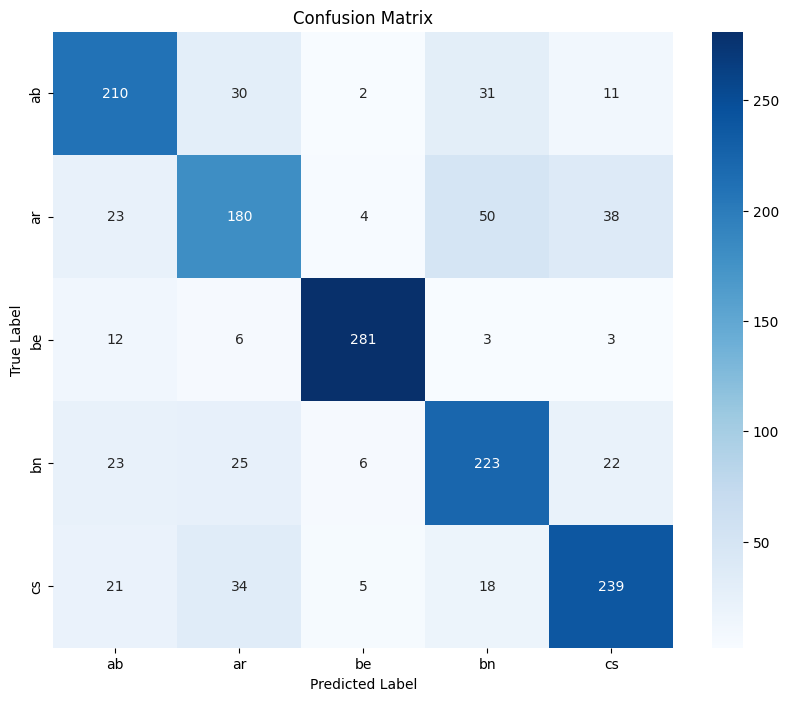

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

          ab       0.73      0.74      0.73       284
          ar       0.65      0.61      0.63       295
          be       0.94      0.92      0.93       305
          bn       0.69      0.75      0.71       299
          cs       0.76      0.75      0.76       317

    accuracy                           0.76      1500
   macro avg       0.75      0.75      0.75      1500
weighted avg       0.76      0.76      0.76      1500



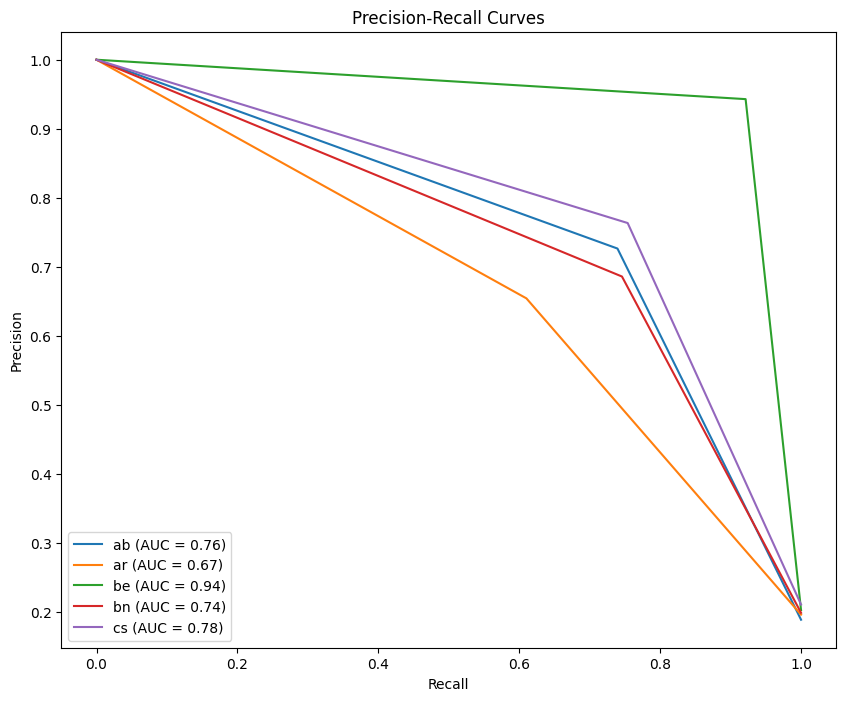

In [12]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test == label_encoder.transform([label]), y_pred == label_encoder.transform([label]))
    area = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {area:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

/tmp/ipykernel_28946/370207174.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')


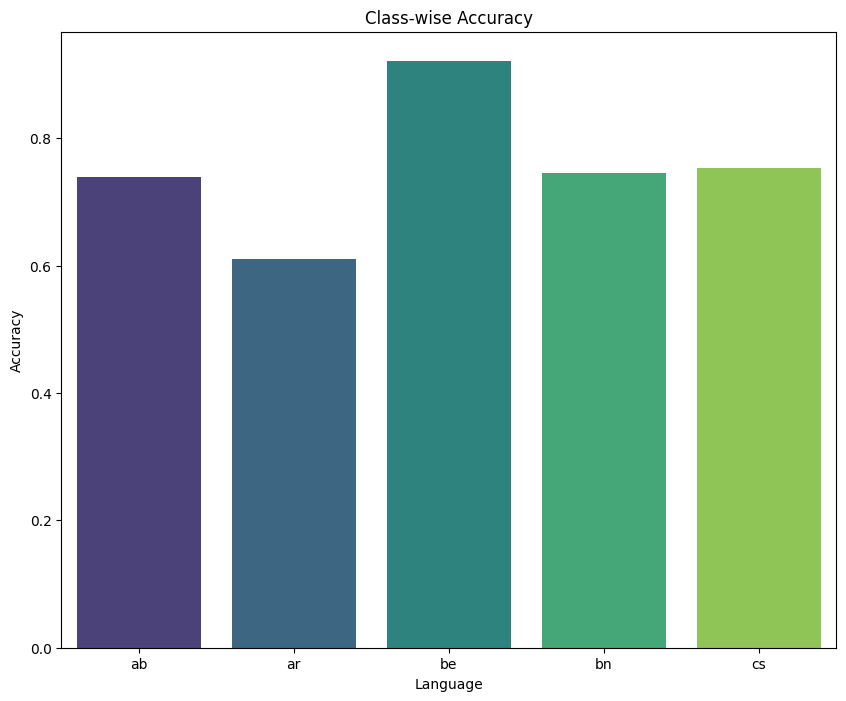

In [13]:
class_accuracy = [accuracy_score(y_test[y_test == label_encoder.transform([label])], y_pred[y_test == label_encoder.transform([label])]) for label in label_encoder.classes_]

plt.figure(figsize=(10, 8))
sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()

## MODEL 2

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
150/150 [==============================] - 3s 14ms/step - loss: 22.4532 - accuracy: 0.3844 - val_loss: 3.9052 - val_accuracy: 0.5700
Epoch 2/10
150/150 [==============================] - 2s 13ms/step - loss: 8.1527 - accuracy: 0.4633 - val_loss: 7.4929 - val_accuracy: 0.4267
Epoch 3/10
150/150 [==============================] - 2s 14ms/step - loss: 4.7714 - accuracy: 0.5344 - val_loss: 2.4939 - val_accuracy: 0.5742
Epoch 4/10
150/150 [==============================] - 2s 12ms/step - loss: 6.3266 - accuracy: 0.5021 - val_loss: 1.8118 - val_accuracy: 0.6650
Epoch 5/10
150/150 [==============================] - 2s 12ms/step - loss: 4.4542 - accuracy: 0.5129 - val_loss: 3.7438 - val_accuracy: 0.5083
Epoch 6/10
150/150 [==============================] - 2s 11ms/step - loss: 2.9351 - accuracy: 0.5410 - val_loss: 2.7758 - val_accuracy: 0.5483
Epoch 7/10
150/150 [==============================] - 2s 10ms/step - loss: 2.9923 - accuracy: 0.5375 - val_loss: 4.2943 - val_accuracy: 0.429

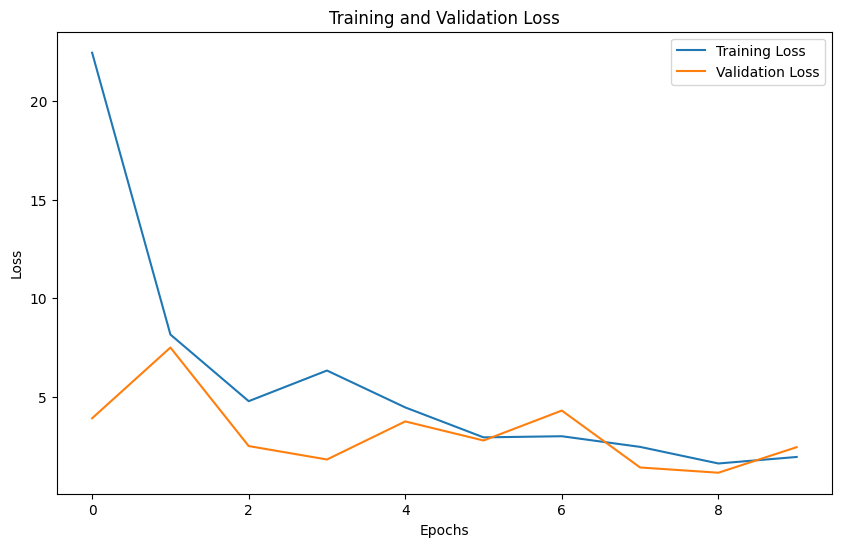

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

47/47 [==============================] - 0s 2ms/step


In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 52.20%


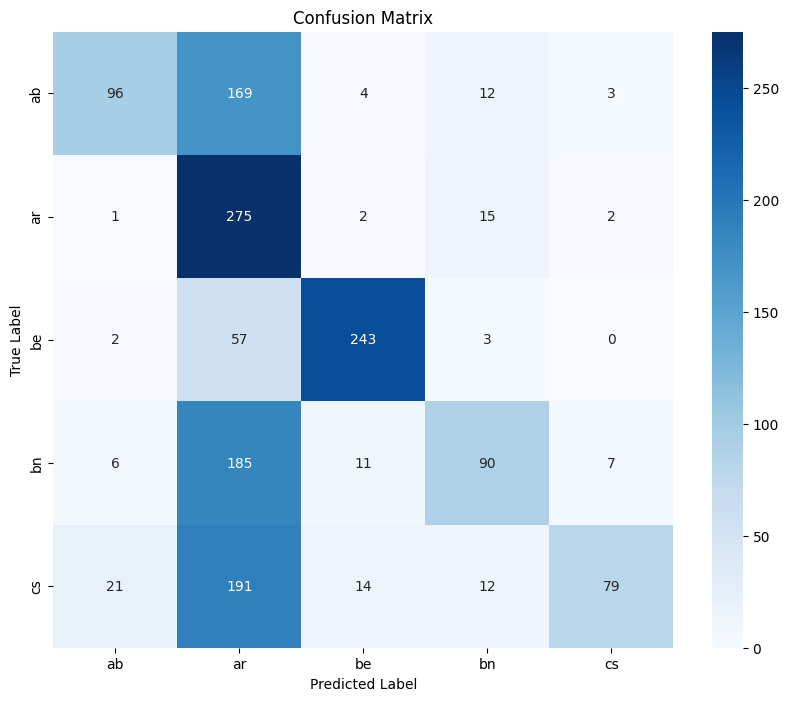

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

          ab       0.76      0.34      0.47       284
          ar       0.31      0.93      0.47       295
          be       0.89      0.80      0.84       305
          bn       0.68      0.30      0.42       299
          cs       0.87      0.25      0.39       317

    accuracy                           0.52      1500
   macro avg       0.70      0.52      0.52      1500
weighted avg       0.71      0.52      0.52      1500



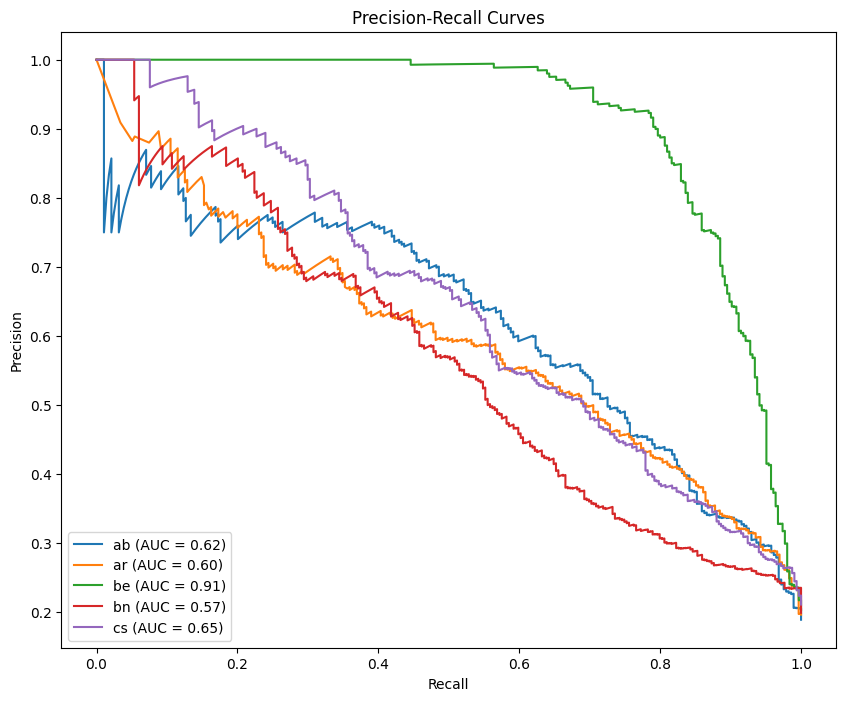

In [25]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test == label_encoder.transform([label]), y_pred_probs[:, i])
    area = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {area:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

/tmp/ipykernel_28946/370207174.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')


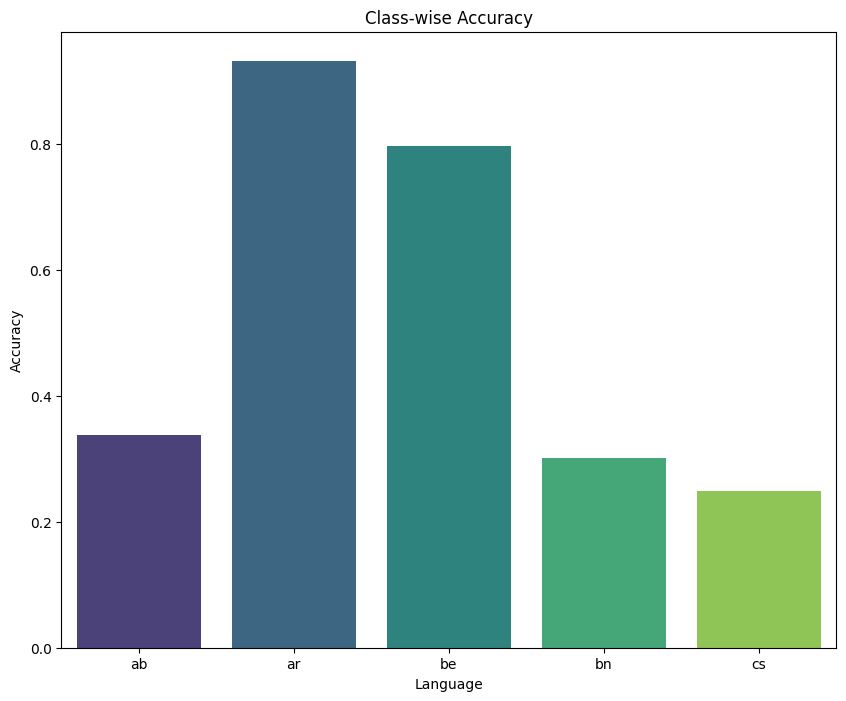

In [26]:
class_accuracy = [accuracy_score(y_test[y_test == label_encoder.transform([label])], y_pred[y_test == label_encoder.transform([label])]) for label in label_encoder.classes_]

plt.figure(figsize=(10, 8))
sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()